# NLP Final Project EDA

#### Peter Charles Bailey (Charlie)
#### CU ID: peba2926

In [11]:
from transformers import BertTokenizer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset

### Data Description

For this project, I will be using the [**dair-ai/emotion**](https://huggingface.co/datasets/dair-ai/emotion) dataset from Hugging Face. There are two configurations of this dataset available—a split and unsplit version.

| Name | Train | Validation | Test |
|------|-------|------------|------|
| split | 16,000 | 2,000 | 2,000 |
| unsplit | 416,809 | N/A | N/A |

To start, I plan to do some exploration with the `split` configuration, then scale up to do a full run on the `unsplit` version.

Both versions have two features:

1. a text string derived from English Twitter messages
2. a numeric classification label with the following possible values: `sadness (0), joy (1), love (2), anger (3), fear (4), surprise (5)`

As noted above, the `split` configuration has 16,000 train instances, 2,000 validation instances,and 2,000 test instances—for a total of 20,000 instances overall.

In [12]:
# load in the split version dataset
ds = load_dataset("dair-ai/emotion", "split")

# create train, validation, and test dataframes
train_df = pd.DataFrame(ds['train'])
validation_df = pd.DataFrame(ds['validation'])
test_df = pd.DataFrame(ds['test'])

# display the first 10 rows of the train dataframe
display(train_df.head(10))

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
5,ive been feeling a little burdened lately wasn...,0
6,ive been taking or milligrams or times recomme...,5
7,i feel as confused about life as a teenager or...,4
8,i have been with petronas for years i feel tha...,1
9,i feel romantic too,2


In [13]:
# confirm dataframe contain correct instances, columns and datatypes
train_df.info()
print("\n")
validation_df.info()
print("\n")
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    16000 non-null  object
 1   label   16000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 250.1+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   label   2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2000 non-null   object
 1   label   2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


In [14]:
# check for missing values
print(f"Train missing values:\n{train_df.isnull().sum()}\n")
print(f"Validation missing values:\n{validation_df.isnull().sum()}\n")
print(f"Test missing values:\n {test_df.isnull().sum()}\n")

Train missing values:
text     0
label    0
dtype: int64

Validation missing values:
text     0
label    0
dtype: int64

Test missing values:
 text     0
label    0
dtype: int64



In [15]:
# check for duplicates
print(f"Train duplicates::: { train_df.duplicated().sum()}")
print(f"Validation duplicates::: { validation_df.duplicated().sum()}")
print(f"Test duplicates::: {test_df.duplicated().sum()}")

Train duplicates::: 1
Validation duplicates::: 0
Test duplicates::: 0


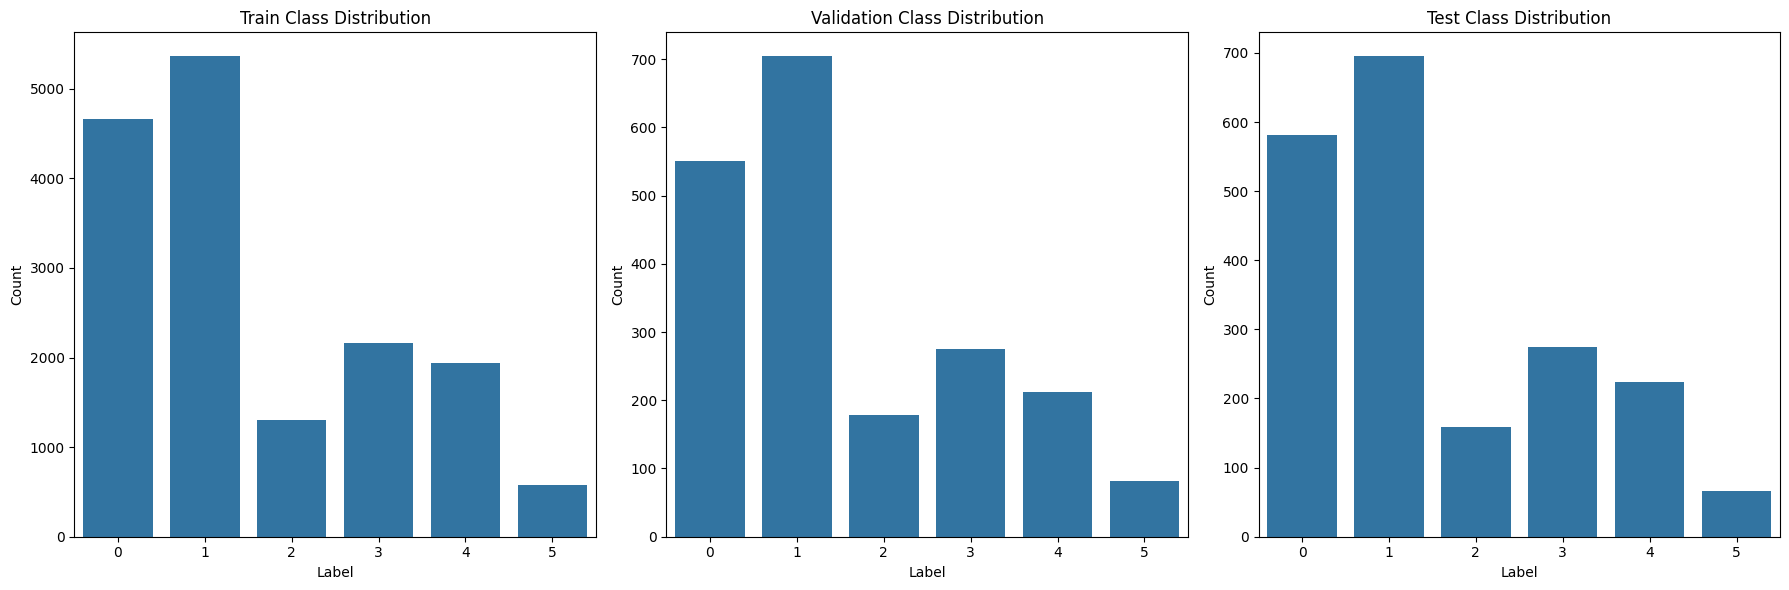

In [16]:
# plot histograms of the class distributions in each dataframe

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# plot histogram for train_df
sns.countplot(x='label', data=train_df, ax=axes[0])
axes[0].set_title('Train Class Distribution')
axes[0].set_xlabel('Label')
axes[0].set_ylabel('Count')

# plot histogram for validation_df
sns.countplot(x='label', data=validation_df, ax=axes[1])
axes[1].set_title('Validation Class Distribution')
axes[1].set_xlabel('Label')
axes[1].set_ylabel('Count')

# plot histogram for test_df
sns.countplot(x='label', data=test_df, ax=axes[2])
axes[2].set_title('Test Class Distribution')
axes[2].set_xlabel('Label')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

For the most part, this dataset is cleaned, in the right format, and ready for processing. There is a single duplicate value, but given the size of the dataset, this will have in indistinguishable impact on performance, so I'm planning to leave it.

One important point to note are the class imbalances. While we see that there is a similar distribution pattern across all three datasets, within each dataset we see that classes 0 and 1 are heavily overrepresented and class 5 in particular is very underrepresented.

We will need to account for these imbalances in both building and evaluating our model. 

#### Determine the appropriate max_length for the tokenizer

In [ ]:
# code citation: Claude 3.7 Sonnet

# get the Bert tokenizer and create new token count column
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# use apply on the text column passing in a lambda function that
# takes the text for each row, encodes it, and returns the length
# this is the token count for the given text
train_df['tokenCount'] = train_df['text'].apply(lambda x: len(tokenizer.encode(x)))


min token count::: 4
max token count::: 87
avg token count::: 22.2595


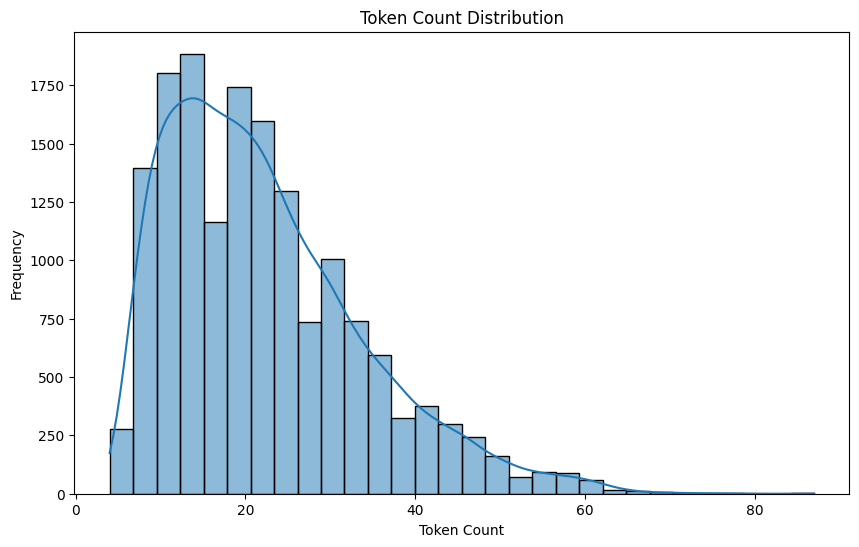

In [18]:
# get the min, max and average token count
min_count = train_df['tokenCount'].min()
max_count = train_df['tokenCount'].max()
avg_count = train_df['tokenCount'].mean()

print(f"min token count::: {min_count}")
print(f"max token count::: {max_count}")
print(f"avg token count::: {avg_count}")

# plot the text length distribution
plt.figure(figsize=(10, 6))
sns.histplot(train_df['tokenCount'], bins=30, kde=True)
plt.title('Token Count Distribution')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.show()

We can see from these statistics that the max token count in our training dataset is 87 tokens. Therefore, to include room for special tokens and maintain computational efficiency, we can comfortable set the max_length of the BertTokenizer to 128 in our implementation.